In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestRegressor
import subprocess
from sklearn.model_selection import RandomizedSearchCV
import sys
import math
import scipy.spatial.distance
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.tree import DecisionTreeRegressor
import os
import shutil
import glob
import shap
from scipy.stats import pearsonr

cmap='viridis'
sys.path.insert(1, '../../')
from LibHelperFuncs import *

rstate = 0
np.random.seed(0)
njob = -1
global_trees = 1000

plt.rcParams['axes.grid'] = False

In [2]:
X = pd.read_csv("../../../Data/Au_nospectra.csv", delimiter=',')
print(X.shape)
Y = X['E_formation']
X = X.iloc[:,1:-5]
X = X.select_dtypes(exclude=['object'])
X = scale_data(X).values

# Y = Y + np.abs(np.min(Y))
# Y /= np.max(Y)

(4000, 373)


In [3]:
def compute_carried_shap(s_vals, comps, X):
    shap_values_r = np.arange(0, X.shape[0]).reshape(-1, 1)
    carried_shap_vals = np.apply_along_axis((lambda x : s_vals[x].reshape(-1, 1).T @ comps), 1, shap_values_r).reshape(-1, X.shape[1])
    return carried_shap_vals

def mean_carried_shap(s_vals, comps, X):
    
    sump = np.sqrt(np.mean(comps ** 2, axis=0))
    sump[np.where(sump == 0)[0]] = 1
    sump = sump ** 2
    sump[np.where(sump < 1e-8)[0]] = 1
    
    t = compute_carried_shap(s_vals, comps, X) / sump
    return np.mean(np.abs(t), axis=0) 

In [4]:
rf = RandomForestRegressor(n_estimators=global_trees, random_state=rstate, n_jobs=-1)
rf.fit(X, Y)

exp = shap.TreeExplainer(rf, feature_perturbation='tree_path_dependant')
s_vals = exp.shap_values(X, approximate=True)
ov_shap = np.mean(np.abs(s_vals), axis=0)

In [5]:
pca = NMF(n_components=50)
pca.fit(X)
# comps = compute_sparse_components(pca.components_, X.shape[1], 0.85)
comps = pca.components_
X_r = (comps @ X.T).T

rf = RandomForestRegressor(n_estimators=global_trees, random_state=rstate, n_jobs=-1)
rf.fit(X_r, Y)

exp = shap.TreeExplainer(rf, feature_perturbation='tree_path_dependant')
s_vals = exp.shap_values(X_r, approximate=True)
ov_reduced_shap = mean_carried_shap(s_vals, pca.components_, X)

In [6]:
rf_params = dict()
rf_params['n_estimators'] = global_trees

In [7]:
urscorecv=[]
rscorecv=[]
urscorel2=[]
rscorel2=[]

renge = range(3, 100)

for k in renge:
    print(k)
    X_l = X[:,np.argsort(ov_shap)[::-1][:k]]

    rf = RandomForestRegressor(**rf_params, n_jobs=njob, random_state=rstate)

    rf.fit(X_l, Y)
    urscorel2.append(np.sqrt(np.mean((rf.predict(X_l) - Y) ** 2)))
    score = cross_val_score(rf, X_l, Y, cv=5, n_jobs=njob, scoring='neg_mean_squared_error')
    urscorecv.append(np.abs(np.mean(score)))

    X_r = X[:,np.argsort(ov_reduced_shap)[::-1][:k]]

    rf = RandomForestRegressor(**rf_params, n_jobs=njob, random_state=rstate)

    rf.fit(X_r, Y)
    rscorel2.append(np.sqrt(np.mean((rf.predict(X_r) - Y) ** 2)))
    score = cross_val_score(rf, X_r, Y, cv=5, n_jobs=njob, scoring='neg_mean_squared_error')
    rscorecv.append(np.abs(np.mean(score)))

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


34978.094311984154 41279.84622925321


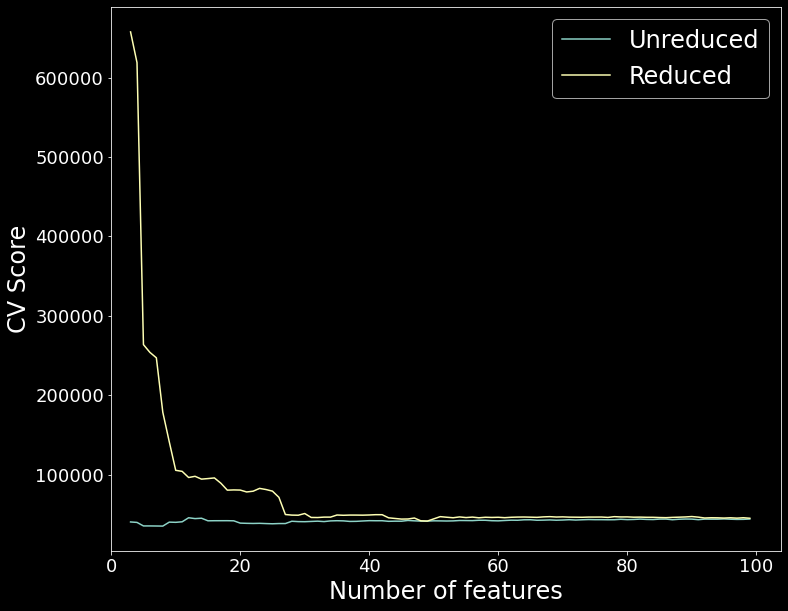

In [8]:
plt.style.use('dark_background')

plt.figure(figsize=(12,10))

plt.plot(renge, urscorecv, label = 'Unreduced')
plt.plot(renge, rscorecv, label='Reduced')

plt.xlabel("Number of features", fontsize=24)
plt.ylabel("CV Score", fontsize=24)
plt.legend(fontsize=24)

print(min(urscorecv), min(rscorecv))
plt.xlim(left=0)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

18.9032457158879 21.77894766345675


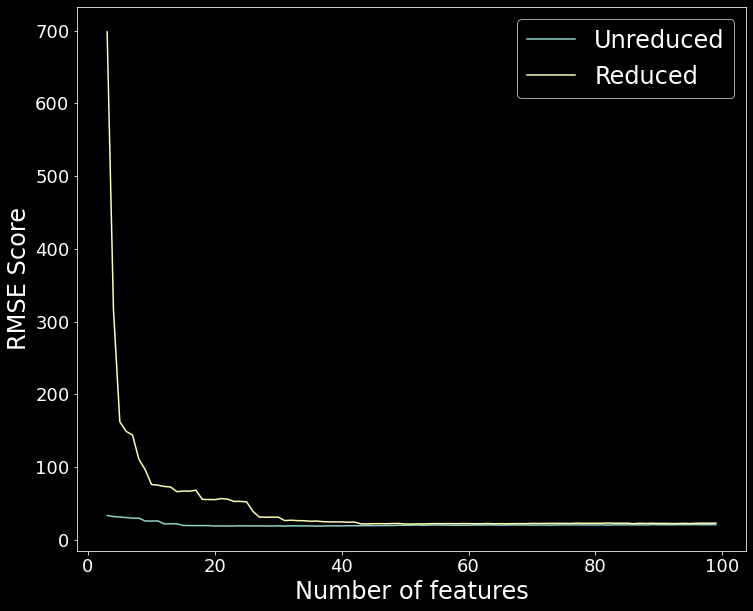

In [9]:
plt.style.use('dark_background')

plt.figure(figsize=(12,10))

plt.plot(renge, urscorel2, label = 'Unreduced')
plt.plot(renge, rscorel2, label='Reduced')

plt.xlabel("Number of features", fontsize=24)
plt.ylabel("RMSE Score", fontsize=24)
plt.legend(fontsize=24)

print(min(urscorel2), min(rscorel2))

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)